# Lab 01 Distance Dependence of Radiation

Team members: Prabh and Noah <br>
Feb. 09, 2026

## Apparatus

![Images/Apparatus.png](Images/Apparatus.png)

In [32]:
# Scientific libraries for analysis
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

## Data loading and cleaning

In [33]:
# load in data
df = pd.read_csv('Data/Lab01_data.csv')
df

,Time (s),closest detector position (cm),Cesium position,distance (cm),dDistance (cm),Measured Counts,dCounts
0,300,NaN,NaN,NaN,NaN,91,9.539392
1,30,98.0,97.5,0.5,0.1,53290,230.846269
2,30,98.0,96.5,1.5,0.1,27541,165.954813
3,30,98.0,95.5,2.5,0.1,11432,106.920531
4,30,98.0,94.5,3.5,0.1,5466,73.932402
5,30,98.0,93.5,4.5,0.1,3261,57.105166
6,30,98.0,91.5,6.5,0.1,1588,39.849718
7,30,98.0,89.5,8.5,0.1,826,28.740216
8,30,98.0,87.5,10.5,0.1,490,22.135944
9,30,98.0,85.5,12.5,0.1,354,18.814888


We approximated $\delta{\rm D}$ (the uncertainty in measured distance) to be approximately 0.1 cm since the markings along the track were spaced by millimeters, so I was confident my distances were to the nearest millimeter for both the cesium-137 holder and the geigen-mueller counter holder

We approximated $\delta{\rm Counts}$ (the uncertainty in the measured counts) to be the $\sqrt{\rm Counts}$ from the formula in the reading, which is derived from the Poisson distribution

In [34]:
# extract background data from dataframe
bg_data = df.iloc[0]

# extract relevant background parameters
bg_time = bg_data['Time (s)']
bg_N = bg_data['Measured Counts']
bg_dN = bg_data['dCounts']

# calculate background 'rate'
bg_rate = bg_N / bg_time
bg_drate = bg_dN / bg_time

print(f'Background rate: {bg_rate:.2f} +/- {bg_drate:.2f}')

# remove background data from dataframe
# remove the first data point (outlier since it was right up against the counter)
dist_data = df.drop(index=[0, 1]).reset_index(drop=True)
dist_data

Background rate: 0.30 +/- 0.03


,Time (s),closest detector position (cm),Cesium position,distance (cm),dDistance (cm),Measured Counts,dCounts
0,30,98.0,96.5,1.5,0.1,27541,165.954813
1,30,98.0,95.5,2.5,0.1,11432,106.920531
2,30,98.0,94.5,3.5,0.1,5466,73.932402
3,30,98.0,93.5,4.5,0.1,3261,57.105166
4,30,98.0,91.5,6.5,0.1,1588,39.849718
5,30,98.0,89.5,8.5,0.1,826,28.740216
6,30,98.0,87.5,10.5,0.1,490,22.135944
7,30,98.0,85.5,12.5,0.1,354,18.814888
8,30,98.0,83.5,14.5,0.1,258,16.062378
9,30,98.0,81.5,16.5,0.1,195,13.964240


The background rate was measured to be 0.30 $\pm$ 0.03 ($ \rm \frac{Counts}{s}$)

In [35]:
# convert distance data to m
dist_data['distance (m)'] = dist_data['distance (cm)'] / 100
dist_data['dDistance (m)'] = dist_data['dDistance (cm)'] / 100

# rates
dist_data['rates (counts/s)'] = dist_data['Measured Counts'] / dist_data['Time (s)']
dist_data['dRates (counts/s)'] = dist_data['dCounts'] / dist_data['Time (s)']

# Background correction
dist_data['corrected rates (counts/s)'] = dist_data['rates (counts/s)'] - bg_rate
dist_data['dCorrected rates (counts/s)'] = (dist_data['dRates (counts/s)']**2 + bg_drate**2)**(1/2)
dist_data['Corrected counts'] = dist_data['corrected rates (counts/s)'] * dist_data['Time (s)']
dist_data['dCorrected counts'] = dist_data['dCorrected rates (counts/s)'] * dist_data['Time (s)']

# drop unnecessary columns
dist_data.drop(['Time (s)','closest detector position (cm)', 'Cesium position', 'distance (cm)', 'dDistance (cm)',
                'Measured Counts', 'dCounts', 'rates (counts/s)', 'dRates (counts/s)',
                'corrected rates (counts/s)', 'dCorrected rates (counts/s)'], axis=1, inplace=True)
dist_data

,distance (m),dDistance (m),Corrected counts,dCorrected counts
0,0.015,0.001,27531.9,165.957555
1,0.025,0.001,11422.9,106.924787
2,0.035,0.001,5456.9,73.938556
3,0.045,0.001,3251.9,57.113133
4,0.065,0.001,1578.9,39.861134
5,0.085,0.001,816.9,28.756043
6,0.105,0.001,480.9,22.156489
7,0.125,0.001,344.9,18.839055
8,0.145,0.001,248.9,16.090681
9,0.165,0.001,185.9,13.996785


Here, we cleaned the data by converting the distance to meter units. <br>

Next, we solved for the count rates by dividing the measured counts by the time over which they were measured (30 s), and then subtracted off the background rate from the count rates, yielding the corrected rate. <Br>

Next, we multiplied the corrected rate by the time over which we measured (30 s) to yield the corrected counts. <br>

Similar techniques were used for $\delta{\rm Counts}$, except we solved for $\delta{\rm Corrected Counts}$ in quadrature with the error in measured and corrected rates

In [36]:
# Extract columns from dataframe
Distance = dist_data['distance (m)']
dDistance = dist_data['dDistance (m)']
Counts = dist_data['Corrected counts']
dCounts = dist_data['dCorrected counts']

## Fitting to the power model

In [37]:
def powerModel(d, A, B):
  N = A * (d**B)
  return N

total_err = (dDistance**2 + dCounts**2)**(1/2)

p, cov = curve_fit(powerModel, Distance, Counts, sigma=total_err, absolute_sigma=True)

A = p[0]; B = p[1]
dA = (cov[0, 0])**(1/2); dB = (cov[1, 1])**(1/2)

print(f'A = {A:.1f} +/- {dA:.1f}')
print(f'B = {B:.3f} +/- {dB:.3f}')

A = 6.3 +/- 0.2
B = -2.004 +/- 0.008


Here, we fit the power model $\rm N(d) = Ad^{B}$ to the data, yielding:

$$ \rm
N(d) = (6.3 \pm 0.2) d^{(-2.004 \pm 0.008)}
$$


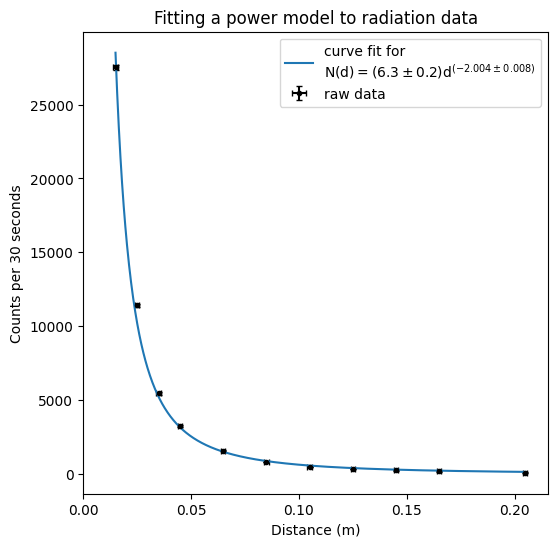

In [38]:
# plotting raw distance vs count data

plt.figure(figsize = (6,6))
plt.errorbar(x = Distance, y = Counts, xerr = dDistance, yerr = dCounts, fmt = '.k', capsize = 2, label = 'raw data')

xvals = np.linspace(min(Distance), max(Distance), 1000)
yvals = powerModel(xvals, A, B)
plt.plot(xvals, yvals, 
  label = (
    'curve fit for\n'
    '$\\rm N(d) = (6.3 \\pm 0.2)d^{(-2.004 \\pm 0.008)}$'
  )
)

plt.legend()

plt.xlabel('Distance (m)')
plt.xticks(np.arange(0, 0.2+0.05, 0.05))

plt.ylabel('Counts per 30 seconds')
plt.title('Fitting a power model to radiation data')

plt.show()

## Linearizing and fitting to the linear model

In [39]:
# Linearizing to a log scale
logDistance = np.log(Distance)
dlogDistance = dDistance/Distance

logCounts = np.log(Counts)
dlogCounts = dCounts/Counts

In [40]:
def linearModel(ln_d, ln_A, B):
  ln_N = ln_A + B * ln_d
  return ln_N

# I wasn't sure if I'm supposed to do the error here in quadrature:
# linear_error = (dlogCounts**2 + dlogDistance**2)**(1/2)
# or just use the yerr here. Doing it in quadrature gives me a
# B value that's far different than the power model
linear_error = dlogCounts

p2, cov2 = curve_fit(linearModel, logDistance, logCounts, sigma=linear_error, absolute_sigma=True)

ln_A = p2[0]; B = p2[1]
dln_A = (cov2[0, 0])**(1/2); dB = (cov2[1, 1])**(1/2)

print(f'ln(A) = {ln_A:.2f} +/- {dln_A:.2f}')
print(f'B = {B:.3f} +/- {dB:.3f}')

ln(A) = 1.91 +/- 0.03
B = -1.989 +/- 0.008


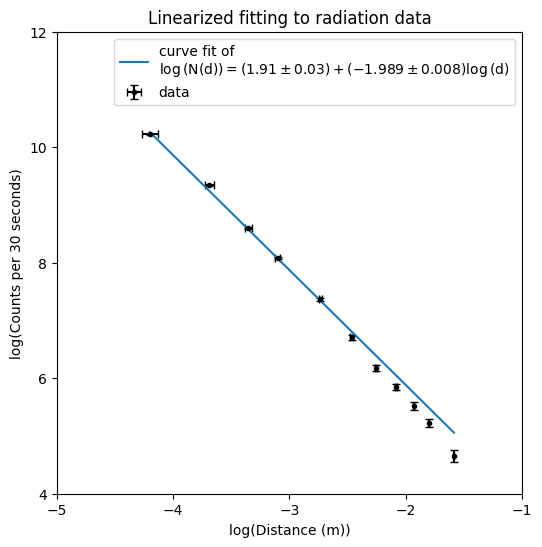

In [41]:
# plotting raw distance vs count data

plt.figure(figsize = (6,6))
plt.errorbar(x = logDistance, y = logCounts, xerr = dlogDistance, yerr = dlogCounts, fmt = '.k', capsize = 3, label = 'data')

xvals = np.linspace(min(logDistance), max(logDistance), 1000)
yvals = linearModel(xvals, ln_A, B)
plt.plot(xvals, yvals, 
  label = f'curve fit of\n'
  '$\\rm \\log{(N(d))} = (1.91 \\pm 0.03) + (-1.989 \\pm 0.008) \\log{(d)}$'
  )

plt.legend()

plt.xlabel('log(Distance (m))')
plt.xlim(-5, -1)
plt.xticks([-5, -4, -3, -2, -1])
plt.ylabel('log(Counts per 30 seconds)')
plt.ylim(4, 12)
plt.yticks([4, 6, 8, 10, 12])
plt.title('Linearized fitting to radiation data')

plt.show()

## Comparison

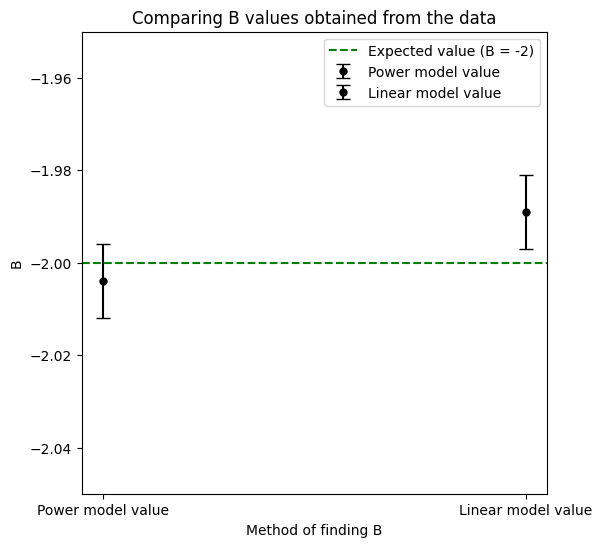

In [42]:
plt.figure(figsize=(6,6))

plt.errorbar(
  x = ['Power model value'],
  y = [-2.004],
  yerr = [0.008],
  capsize = 5,
  fmt = '.',
  markersize = 10,
  color = 'black',
  label = 'Power model value'
)

plt.errorbar(
  x = ['Linear model value'],
  y = [-1.989],
  yerr = [0.008],
  capsize = 5,
  fmt = '.',
  markersize = 10,
  color = 'black',
  label = 'Linear model value'
)
plt.axhline(y = -2, linestyle = '--', color = 'green', label = 'Expected value (B = -2)')

plt.ylim(-2.05, -1.95)
plt.ylabel('B')

plt.xlabel('Method of finding B')

plt.title('Comparing B values obtained from the data')

plt.legend()
plt.show()

The expected value for B is within the uncertainty for the B value determined via the power model fit, but lies just outside the uncertainty for the B value determined via the linear model fit. This discrepency could be due to issues with error propogation to the log scale. <br>
<br>
**Overall, the experimental data supports the notion of an inverse square law for the distance dependence of radiation**

## Explanations

#### Dominant Source of Uncertainty

First, we calculate the fractional uncertainty formulas

$\rm \frac{\delta{ N_d }}{N} = \frac{|\frac{\partial N}{\partial d}| \delta{d} }{N} = \frac{|\frac{B}{d}N|\delta{d}}{N} = |\frac{B}{d}|\delta{d}$

$\frac{\partial N_C}{N} = \frac{\sqrt{N}}{N} = \frac{1}{\sqrt{N}}$

In [43]:
# We had B appoximatley -2, and delta d approximatley 0.001
# I will calculate the fractional uncertainty for each count-distance measurement:

B = -2.0
delta_d = 0.001  # m

frac_dist = (abs(B) / Distance) * delta_d
frac_count = 1 / np.sqrt(Counts)

var_dist = frac_dist**2
var_count = frac_count**2

pd.DataFrame({
  'distance': Distance,
  'Frac dist contrib': frac_dist,
  'Frac count contrib': frac_count,
})

,distance,Frac dist contrib,Frac count contrib
0,0.015,0.133333,0.006027
1,0.025,0.080000,0.009356
2,0.035,0.057143,0.013537
3,0.045,0.044444,0.017536
4,0.065,0.030769,0.025166
5,0.085,0.023529,0.034988
6,0.105,0.019048,0.045601
7,0.125,0.016000,0.053846
8,0.145,0.013793,0.063385
9,0.165,0.012121,0.073343


The dominant source of uncertainty for this lab was $\rm \delta{d}$ at close distances ($\lt 0.08$ m), and was $\rm \delta{N}$ at far distances ($\gt 0.08$ m) as seen from the fractional uncertainties table above

## Connection to Physics

This experiment was to determine the validity of the inverse square law (distance dependence) of radiation by analyzing counts measured from radioactive particles hitting the geigen-mueller device. We expect that the number of photons detected is proportional with the inverse square of distance:

$$
\rm N(d) = \frac{\Phi}{4 \pi d^2}
$$

We tested this by fitting experimental data to a power law:
$$
\rm N(d) = A d^B
$$

and determining the parameter value for B (and its uncertainty). <br>
<br>
Upon fitting to this power law, we obtained the value for B = (-2.004 $\pm$ 0.008), which matches the expected value of -2 for the inverse square law. <br>
<br>
We took this one step further by linearizing the power law by taking the natural log of the power law:
$$
\rm \log{(N(d))} = \log{(A)} + B \log({d})
$$

Which we fit the log of the experimental data to determine the parameter value of B (and uncertainty) = (-1.989 $\pm$ 0.008)